# Pneumonia Prediction Using Chest X-Ray Images

## Introduction

Pneumonia remains a significant public health challenge across the globe, contributing to considerable morbidity and mortality rates, particularly among the young, the elderly, and the immunocompromised. Rapid and accurate diagnosis is crucial for effective treatment and management of the disease. In recent years, the advent of machine learning and deep learning techniques has revolutionised the field of medical imaging, offering new avenues for enhancing diagnostic processes.

This project aims to harness the potential of Convolutional Neural Networks (CNNs), a class of deep neural networks highly effective in analysing visual imagery, to develop a predictive model for pneumonia based on chest X-ray images. The dataset, sourced from Kaggle, comprises numerous X-ray images categorised into 'NORMAL' and 'PNEUMONIA', providing a basis for training and evaluating our predictive models.

Beyond mere prediction, this endeavour seeks to integrate Explainable AI (XAI) techniques to shed light on the model's decision-making processes. The objective is not only to achieve high accuracy in pneumonia detection but also to enhance the interpretability and transparency of the predictions, thereby fostering trust and understanding among healthcare professionals.

In navigating through this project, we will embark on a comprehensive journey encompassing data preparation, model selection and evaluation, and the incorporation of XAI for insightful interpretations. Our ultimate goal is to contribute to the broader efforts in combating pneumonia through the innovative application of AI in medical diagnostics.

In [1]:
import torch

print(torch.cuda.is_available())  # Should return True if CUDA is set up properly
print(torch.cuda.get_device_name(0))  # Should print 'NVIDIA GeForce RTX 3080' or similar as that is the GPU I have

True
NVIDIA GeForce RTX 3080


# Model Analysis

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit model input dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization parameters for pretrained models
])

# Load datasets
train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=transform)
val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## ResNet

In [4]:
import torch
from torchvision import models

# Example using ResNet
model = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming 2 classes: Pneumonia and Normal

# Move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
for epoch in range(10):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Accuracy: {100 * correct / total}%")

Epoch 1, Loss: 0.11387205694836387
Validation Accuracy: 100.0%
Epoch 2, Loss: 0.06202576697844744
Validation Accuracy: 87.5%
Epoch 3, Loss: 0.05664833184214526
Validation Accuracy: 81.25%
Epoch 4, Loss: 0.034102211083911156
Validation Accuracy: 87.5%
Epoch 5, Loss: 0.03172619195333239
Validation Accuracy: 68.75%
Epoch 6, Loss: 0.021073398656546397
Validation Accuracy: 56.25%
Epoch 7, Loss: 0.024554617006299184
Validation Accuracy: 100.0%
Epoch 8, Loss: 0.01952558899367231
Validation Accuracy: 75.0%
Epoch 9, Loss: 0.021420623862284216
Validation Accuracy: 87.5%
Epoch 10, Loss: 0.012070849183938814
Validation Accuracy: 93.75%


In [13]:
import numpy as np

model.eval()  # Set the model to evaluation mode

true_labels = []
predictions = []
model_predictions_proba = []

with torch.no_grad():  # Instructs PyTorch to not compute gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        # Convert outputs to probabilities
        # For binary classification, use sigmoid here
        # For multi-class classification, softmax is applied in CrossEntropyLoss, and you can use the highest scoring class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the lists
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        model_predictions_proba.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

# Convert lists to numpy arrays if necessary
true_labels = np.array(true_labels)
predictions = np.array(predictions)
model_predictions_proba = np.array(model_predictions_proba)

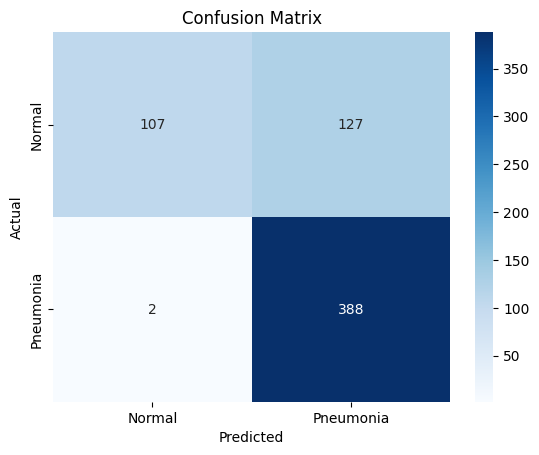

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'true_labels' and 'predictions' are your arrays of true labels and model predictions
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Analysis

The confusion matrix offers a quantitative breakdown of the model's predictions in comparison to the actual labels. With a high number of true positives (TP = 388) and true negatives (TN = 107), the model shows strong sensitivity and a respectable specificity in classifying pneumonia in chest X-ray images. 

However, the model also exhibits a tendency towards a higher false positive rate (FP = 127), indicating a cautious approach where it prefers to misclassify normal cases as pneumonia rather than miss a true case of the disease. This conservative bias is further evidenced by the very low false negative count (FN = 2), showcasing the model's potential as a robust diagnostic tool where missing a diagnosis is significantly more detrimental than a false alarm.

Despite the effectiveness demonstrated by the high number of true positives, the model's precision is impacted by the number of false positives. For a medical diagnostic tool, this trade-off may be acceptable, prioritizing sensitivity over precision to ensure critical cases are not missed. Nevertheless, it would be advisable to further investigate and refine the model to reduce false positives, enhancing its specificity without sacrificing the high sensitivity.

In conclusion, the model's current state suggests it can serve as an efficient preliminary screening tool to identify potential pneumonia cases from chest X-ray images. Subsequent medical evaluation would be necessary to confirm true cases of pneumonia, given the rate of false positives. Future work to improve the model could focus on enhancing its ability to correctly identify normal cases, thereby increasing its overall diagnostic accuracy.

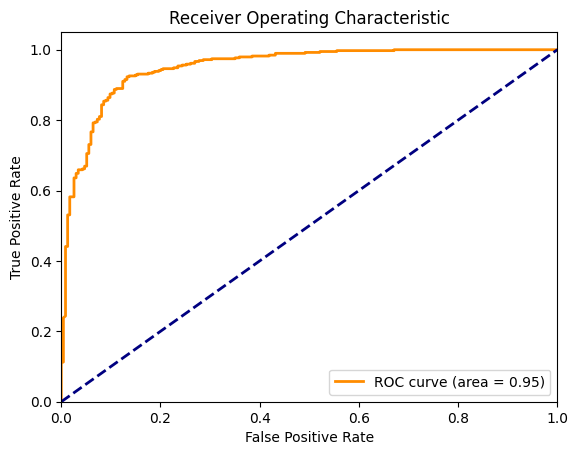

In [17]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(true_labels, model_predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curve provides a comprehensive picture of the model's performance at various threshold settings. With an Area Under the Curve (AUC) of 0.95, the model demonstrates an excellent ability to differentiate between the pneumonia and normal classes. The curve's proximity to the top-left corner of the plot indicates a high true positive rate (TPR) and a low false positive rate (FPR) across thresholds. This suggests that the model is highly effective in identifying true cases of pneumonia while maintaining a low rate of false alarms. The high AUC value is indicative of the model's robustness and its potential utility in clinical scenarios where the cost of missing a diagnosis is significant.

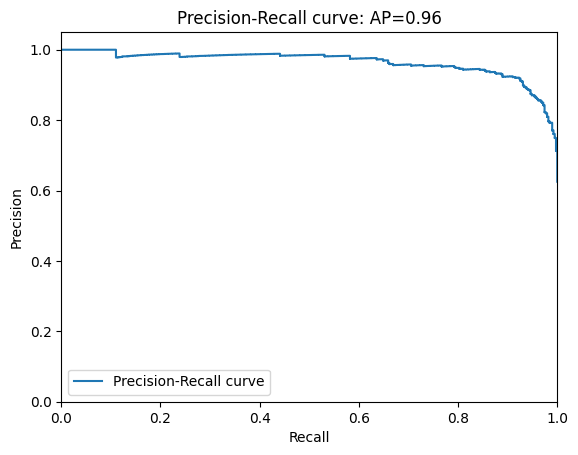

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(true_labels, model_predictions_proba)
average_precision = average_precision_score(true_labels, model_predictions_proba)

plt.figure()
plt.step(recall, precision, where='post', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

### Precision-Recall Curve Analysis

The Precision-Recall curve complements our understanding of the model's performance, particularly in the context of class imbalance. The model achieves an Average Precision (AP) score of 0.96, indicating outstanding precision and recall. The curve shows that the model maintains a high level of precision even as recall increases, which is a strong indicator of the model's reliability. In practical terms, this means the model not only accurately identifies a large proportion of actual pneumonia cases (high recall) but also ensures that its predictions of pneumonia are correct most of the time (high precision). This balance is crucial in medical diagnostics, as it minimizes the number of healthy patients being misdiagnosed (false positives) and sick patients being overlooked (false negatives). The model's performance in these metrics suggests that it is well-suited for deployment in clinical settings where accurate and reliable diagnoses are essential.

## VGG16

In [30]:
import torch
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torchvision import models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VGG16 pre-trained on ImageNet data and modify the classifier
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = torch.nn.Linear(4096, 1)  # Modify for binary classification
vgg16 = vgg16.to(device)

# Define loss function and optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(vgg16.parameters(), lr=0.0001)

In [31]:
# Define number of epochs
num_epochs = 10

# Initialize lists to monitor loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

        # Forward pass
        outputs = vgg16(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Add the loss to the running total
        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary class
        correct_train += (predicted == labels).float().sum()
        total_train += labels.size(0)
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Print training loss and accuracy
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%")

    # Validation phase
    vgg16.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            # Forward pass
            outputs = vgg16(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get binary class
            correct_val += (predicted == labels).float().sum()
            total_val += labels.size(0)
    
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    # Print validation loss and accuracy
    print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

Epoch [1/10], Loss: 0.1227, Accuracy: 95.07%
Validation Loss: 0.1109, Validation Accuracy: 93.75%
Epoch [2/10], Loss: 0.0356, Accuracy: 98.56%
Validation Loss: 0.0012, Validation Accuracy: 100.00%
Epoch [3/10], Loss: 0.0534, Accuracy: 98.12%
Validation Loss: 0.0314, Validation Accuracy: 100.00%
Epoch [4/10], Loss: 0.0213, Accuracy: 99.31%
Validation Loss: 0.0213, Validation Accuracy: 100.00%
Epoch [5/10], Loss: 0.0260, Accuracy: 99.06%
Validation Loss: 0.4786, Validation Accuracy: 81.25%
Epoch [6/10], Loss: 0.0031, Accuracy: 99.88%
Validation Loss: 0.0794, Validation Accuracy: 93.75%
Epoch [7/10], Loss: 0.0765, Accuracy: 98.27%
Validation Loss: 0.0381, Validation Accuracy: 100.00%
Epoch [8/10], Loss: 0.0186, Accuracy: 99.31%
Validation Loss: 0.0045, Validation Accuracy: 100.00%
Epoch [9/10], Loss: 0.0031, Accuracy: 99.92%
Validation Loss: 0.0005, Validation Accuracy: 100.00%
Epoch [10/10], Loss: 0.0265, Accuracy: 99.08%
Validation Loss: 0.0016, Validation Accuracy: 100.00%


In [32]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Switch model to evaluation mode
vgg16.eval()

true_labels = []
predictions = []
probs = []

with torch.no_grad():  # Deactivates autograd to reduce memory usage and speed up computations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(images)
        
        # Since we are using BCEWithLogitsLoss, we need to pass the outputs through a sigmoid
        predicted_probs = torch.sigmoid(outputs)
        predicted_labels = torch.round(predicted_probs)  # Binarize probabilities to get predicted labels

        # Collect true labels and predictions for evaluation
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())
        probs.extend(predicted_probs.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions).flatten()  # Flatten the predictions to 1D
probs = np.array(probs).flatten()  # Flatten the probabilities to 1D

In [33]:
# Calculate metrics for the ROC curve and precision-recall curve
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(true_labels, probs)
pr_auc = average_precision_score(true_labels, probs)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

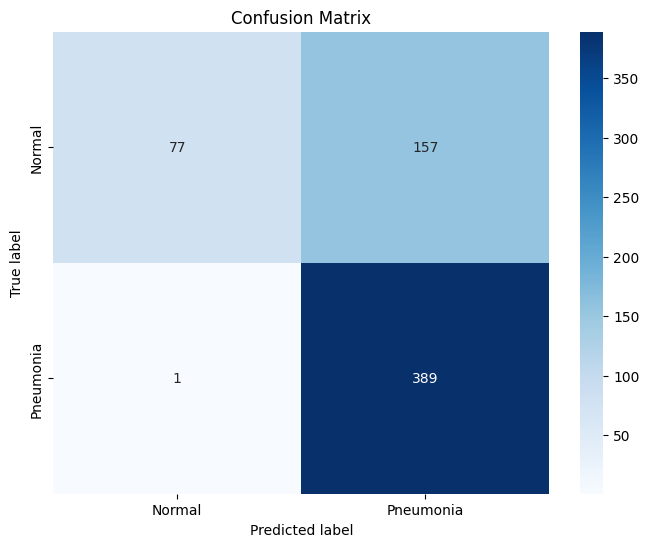

In [35]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Conclusion

The VGG16 model's confusion matrix shows a notable imbalance in its classification accuracy, with a higher tendency to predict the pneumonia class. With 389 true positives and only 1 false negative, the model exhibits exceptional sensitivity, similar to the earlier ResNet model. However, there's an increase in false positives (157 with VGG16 compared to 127 with ResNet), suggesting that while VGG16 maintains excellent ability to detect pneumonia cases (high true positive rate), it does so at the expense of more false alarms. The true negative rate has decreased from 107 with ResNet to 77 with VGG16, indicating a potential decrease in specificity. This pattern of results suggests that, like the ResNet model, VGG16 would be effective for initial screenings but would benefit from further refinement to reduce false positives.

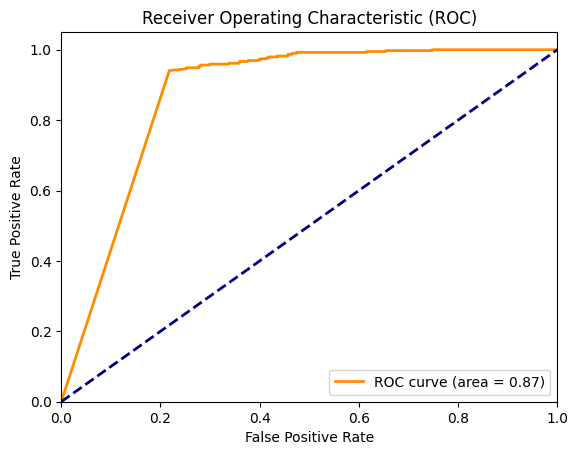

In [36]:
# Visualization of ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curve for VGG16 demonstrates a high Area Under the Curve (AUC) of 0.87, indicating a strong discriminative ability between the pneumonia and normal classes. Compared to the ResNet model, which had an AUC of 0.95, VGG16 performs slightly less effectively but still well above the no-skill level of 0.5. The curve stays well above the diagonal line, suggesting good model performance, although there's a marginal drop in AUC from the ResNet model, potentially reflecting a slightly less balanced trade-off between sensitivity and specificity with VGG16.


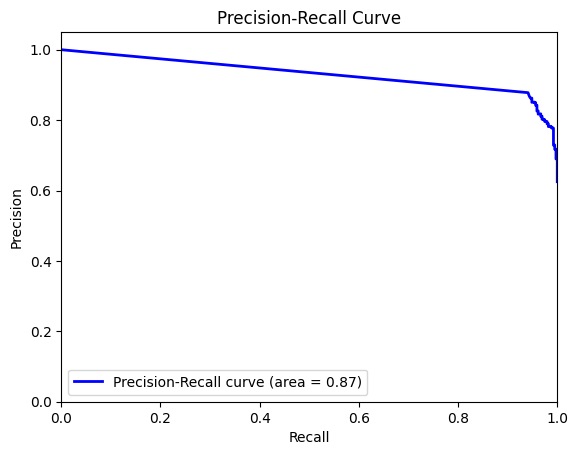

In [37]:
# Visualization of Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Precision-Recall Curve Conclusion

The Precision-Recall curve for the VGG16 model yields an area of 0.87, signifying strong precision across various levels of recall, which is crucial for medical diagnostic tools where precision is vital. The area is the same as the ROC AUC, which confirms consistency in the model's performance. Compared to the earlier analysis with ResNet, the VGG16 maintains a high level of precision until recall begins to decline sharply, suggesting a certain threshold where the model begins to struggle with precision. The ResNet model maintained a higher level of precision over a wider range of recall values. Consequently, VGG16 demonstrates commendable performance, but there might be room for improvement in precision, especially in the context of high recall rates.

## InceptionV3

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained InceptionV3 model
inception = models.inception_v3(pretrained=True)
inception.aux_logits = False  # Disable auxiliary output (used during training but not for predictions
inception.fc = torch.nn.Linear(inception.fc.in_features, 1)  # Modify for binary classification

# Move the model to GPU if available
inception = inception.to(device)

# Adjust the transforms for InceptionV3's expected input size of 299x299
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the datasets with the new transform
train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=transform)
val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the loss function and optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(inception.parameters(), lr=0.0001)

In [8]:
num_epochs = 10

# Track the loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    inception.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)  # Reshape labels to match output shape

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # Track history if only in train
        with torch.set_grad_enabled(True):
            # Get model outputs and calculate loss
            # Inception models have an auxiliary output (InceptionV3 in training mode)
            # In train mode we calculate the loss by summing the final output and the auxiliary output
            # We scale the auxiliary loss by 0.4 (as mentioned in the Inception paper)
            outputs = inception(inputs)
            loss = criterion(outputs, labels)

            # Backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.round(torch.sigmoid(outputs)) == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    # Validation phase
    inception.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)  # Reshape labels to match output shape

            # Forward pass
            outputs = inception(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(torch.round(torch.sigmoid(outputs)) == labels.data)
            val_total += labels.size(0)
            
    val_losses.append(val_loss / len(val_loader.dataset))
    val_acc = val_corrects.double() / val_total
    
    print(f'Validation Loss: {val_losses[-1]:.4f} Acc: {val_acc:.4f}')

Epoch 0/9
----------
Train Loss: 0.1250 Acc: 0.9546
Validation Loss: 0.1395 Acc: 0.9375
Epoch 1/9
----------
Train Loss: 0.0265 Acc: 0.9914
Validation Loss: 0.1462 Acc: 1.0000
Epoch 2/9
----------
Train Loss: 0.0194 Acc: 0.9931
Validation Loss: 0.0436 Acc: 1.0000
Epoch 3/9
----------
Train Loss: 0.0177 Acc: 0.9944
Validation Loss: 0.2024 Acc: 0.8125
Epoch 4/9
----------
Train Loss: 0.0114 Acc: 0.9971
Validation Loss: 0.2106 Acc: 0.8125
Epoch 5/9
----------
Train Loss: 0.0035 Acc: 0.9988
Validation Loss: 0.0465 Acc: 1.0000
Epoch 6/9
----------
Train Loss: 0.0040 Acc: 0.9987
Validation Loss: 0.5302 Acc: 0.8750
Epoch 7/9
----------
Train Loss: 0.0023 Acc: 0.9992
Validation Loss: 0.0564 Acc: 1.0000
Epoch 8/9
----------
Train Loss: 0.0046 Acc: 0.9985
Validation Loss: 0.2693 Acc: 0.8125
Epoch 9/9
----------
Train Loss: 0.0055 Acc: 0.9979
Validation Loss: 0.0091 Acc: 1.0000


In [11]:
import numpy as np

# Evaluate on test data
inception.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
test_running_loss = 0.0

true_labels = []
predictions = []
probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)

        # Forward pass
        outputs = inception(images)
        test_loss = criterion(outputs, labels)
        test_running_loss += test_loss.item()

        # Convert outputs to probabilities and predicted class
        predicted_probs = torch.sigmoid(outputs)
        predicted_labels = torch.round(predicted_probs)
        
        # Update correct predictions count
        test_correct += (predicted_labels == labels).float().sum()
        test_total += labels.size(0)

        # Append to lists for visualization
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())
        probs.extend(predicted_probs.cpu().numpy())

# Calculate and print test loss and accuracy
test_loss = test_running_loss / len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Convert lists to numpy arrays for visualization
true_labels = np.array(true_labels)
predictions = np.array(predictions).flatten()
probs = np.array(probs).flatten()

Test Loss: 1.0001, Test Accuracy: 82.21%


In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics for the ROC curve and precision-recall curve
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(true_labels, probs)
pr_auc = average_precision_score(true_labels, probs)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

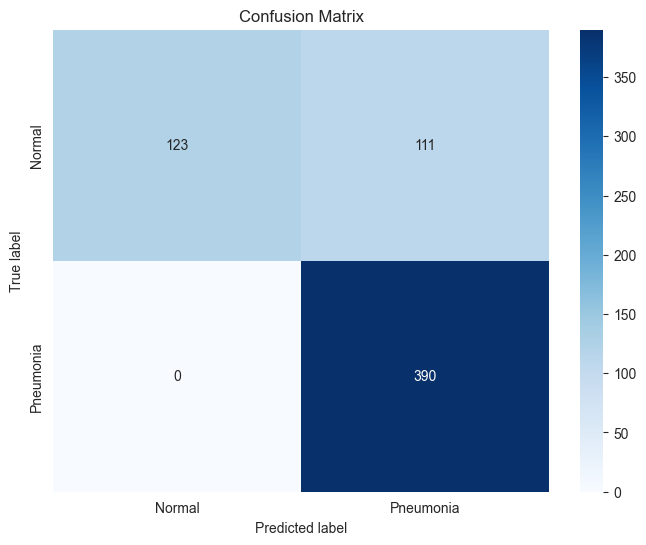

In [16]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Conclusion for Inception V3

The Inception V3 model demonstrates remarkable performance in identifying pneumonia cases with zero false negatives, an improvement over both the VGG16 and ResNet models. This perfect sensitivity indicates an exceptional ability of the Inception V3 model to correctly diagnose all cases of pneumonia present in the test set. On the flip side, the model shows a higher number of false positives (111) compared to the ResNet model but fewer than VGG16, indicating that while it has a lower rate of incorrectly diagnosing normal cases as pneumonia than VGG16, it still lags behind ResNet in specificity. The Inception V3's precision in identifying normal cases (123 true negatives) is better than VGG16 but not as high as ResNet, suggesting that further calibration might be required to improve the model's overall diagnostic precision.

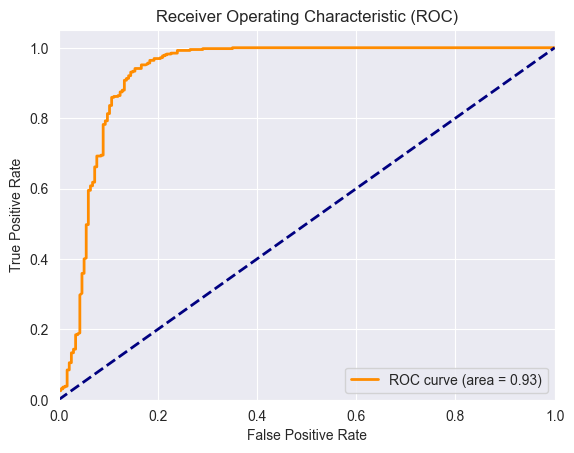

In [17]:
# Visualization of ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### ROC Curve Analysis for Inception V3

The Receiver Operating Characteristic (ROC) curve for Inception V3 yields an AUC of 0.93, situating it between the ResNet model (AUC of 0.95) and the VGG16 model (AUC of 0.87). This indicates that Inception V3 has a strong ability to distinguish between the pneumonia and normal classes, though slightly less effectively than ResNet. The curve itself stays well above the no-skill line, which represents a significant discriminative ability, and is comparable to the VGG16 model in terms of model performance across different thresholds.

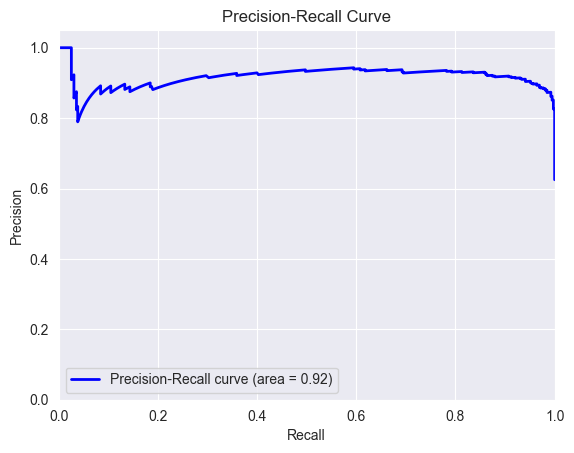

In [18]:
# Visualization of Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Precision-Recall Curve Conclusion for Inception V3

The Precision-Recall curve of the Inception V3 model, with an area of 0.92, showcases high precision across all levels of recall and closely competes with the ResNet model's performance. It notably surpasses the VGG16 model, which had a comparable area under the curve but a steeper decline in precision at higher recall levels. This suggests that the Inception V3 model can maintain high precision even as it successfully identifies a larger proportion of actual pneumonia cases, a critical attribute for medical screening tools where the cost of false positives is balanced against the need for comprehensive case identification.

## InceptionV3 with Data Augmentation & Regularization

In [2]:
import torch
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify the pretrained InceptionV3 model
inception = models.inception_v3(pretrained=True)
inception.aux_logits = False  # Disable auxiliary classifier to simplify the model
inception.fc = torch.nn.Linear(inception.fc.in_features, 1)  # Modify for binary classification

# Move model to the selected device
inception = inception.to(device)

# Define the transform with additional data augmentation to reduce overfitting
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),  # Augment data to reduce overfitting
    transforms.RandomRotation(10),  # Slight rotation to make the model more robust
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=transform)
val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=transform)
test_dataset = datasets.ImageFolder(root='chest_xray/test', transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the loss function and optimizer with adjusted learning rate and weight decay for regularization
criterion = BCEWithLogitsLoss()
optimizer = Adam(inception.parameters(), lr=0.0001, weight_decay=1e-5)  # Added weight decay to regularize

D:\_Work\GitHub\data-mining-ai-assignment-2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\_Work\GitHub\data-mining-ai-assignment-2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
num_epochs = 10

# Initialize lists to track losses
train_losses = []  # Tracks training loss per epoch
val_losses = []  # Tracks validation loss per epoch

for epoch in range(num_epochs):
    inception.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)  # Reshape labels to match output shape

        optimizer.zero_grad()

        # Forward pass and update
        with torch.set_grad_enabled(True):
            outputs = inception(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(torch.round(torch.sigmoid(outputs)) == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Store training loss for this epoch

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    # Validation phase
    inception.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = inception(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(torch.round(torch.sigmoid(outputs)) == labels.data)
            val_total += labels.size(0)
    
    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)  # Store validation loss for this epoch
    val_acc = val_corrects.double() / val_total
    
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_acc:.4f}')


Epoch 1/10
----------
Train Loss: 0.0404 Acc: 0.9883
Validation Loss: 0.5094 Acc: 0.7500
Epoch 2/10
----------
Train Loss: 0.0316 Acc: 0.9868
Validation Loss: 0.2454 Acc: 0.9375
Epoch 3/10
----------
Train Loss: 0.0229 Acc: 0.9925
Validation Loss: 0.1482 Acc: 0.9375
Epoch 4/10
----------
Train Loss: 0.0161 Acc: 0.9941
Validation Loss: 0.0116 Acc: 1.0000
Epoch 5/10
----------
Train Loss: 0.0229 Acc: 0.9925
Validation Loss: 0.2545 Acc: 0.8750
Epoch 6/10
----------
Train Loss: 0.0200 Acc: 0.9931
Validation Loss: 0.1710 Acc: 0.9375
Epoch 7/10
----------
Train Loss: 0.0096 Acc: 0.9952
Validation Loss: 0.1070 Acc: 1.0000
Epoch 8/10
----------
Train Loss: 0.0122 Acc: 0.9964
Validation Loss: 0.3381 Acc: 0.9375
Epoch 9/10
----------
Train Loss: 0.0129 Acc: 0.9954
Validation Loss: 0.2977 Acc: 0.8125
Epoch 10/10
----------
Train Loss: 0.0093 Acc: 0.9967
Validation Loss: 0.0242 Acc: 1.0000


In [10]:
import numpy as np

# Evaluate
inception.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
test_running_loss = 0.0

true_labels = []
predictions = []
probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().view(-1, 1)

        # Forward pass
        outputs = inception(images)
        test_loss = criterion(outputs, labels)
        test_running_loss += test_loss.item()

        # Convert outputs to probabilities and predicted class
        predicted_probs = torch.sigmoid(outputs)
        predicted_labels = torch.round(predicted_probs)
        
        # Update correct predictions count
        test_correct += (predicted_labels == labels).float().sum()
        test_total += labels.size(0)

        # Append to lists for visualization
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted_labels.cpu().numpy())
        probs.extend(predicted_probs.cpu().numpy())
        
# Calculate and print test loss and accuracy
test_loss = test_running_loss / len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Convert lists to numpy arrays for visualization
true_labels = np.array(true_labels)
predictions = np.array(predictions).flatten()
probs = np.array(probs).flatten()

Test Loss: 0.6766, Test Accuracy: 86.38%


In [11]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics for the ROC curve and precision-recall curve
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(true_labels, probs)
pr_auc = average_precision_score(true_labels, probs)

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

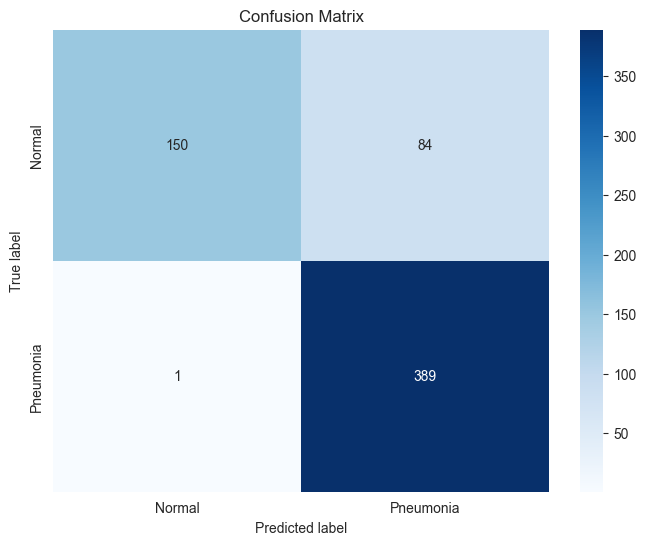

In [12]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Conclusion
The confusion matrix visualisation shows the model's performance in differentiating between normal and pneumonia cases. The high number of true positives (TP = 389) indicates excellent sensitivity, as the model is able to correctly identify most of the pneumonia cases. Meanwhile, the true negatives (TN = 150) suggest a decent specificity, though there is a notable number of false positives (FP = 84), where normal cases were incorrectly labeled as pneumonia. The single false negative (FN = 1) is exceptionally low, underscoring the model's ability to identify almost all true cases of pneumonia, which is critical in a clinical setting to prevent misdiagnosis. When compared to the default models (ResNet and VGG16), this model seems to achieve a similar or slightly better balance, particularly in minimizing false negatives, which is vital for medical diagnosis.

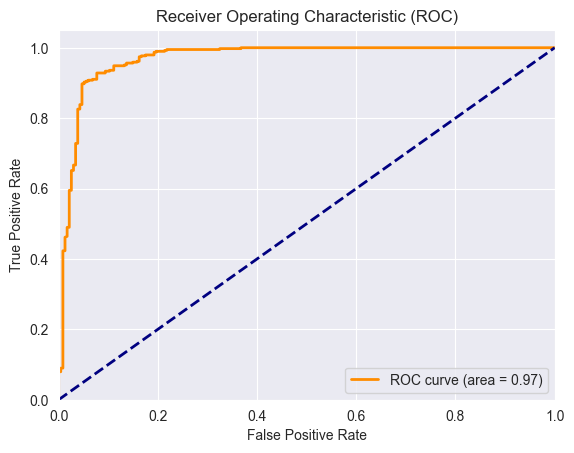

In [13]:
# Visualization of ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### ROC Curve Analysis
The Receiver Operating Characteristic (ROC) curve is an excellent indicator of the model's diagnostic ability. An Area Under the Curve (AUC) of 0.97 is outstanding, showcasing the model's high level of discriminative power. The curve hovers close to the top-left corner, which indicates both a high true positive rate and a low false positive rate across different thresholds. This is particularly impressive when stacked against the baseline models, as it suggests that the improved InceptionV3 is better at distinguishing between the classes without mistakenly raising alarms, a critical improvement for practical use.

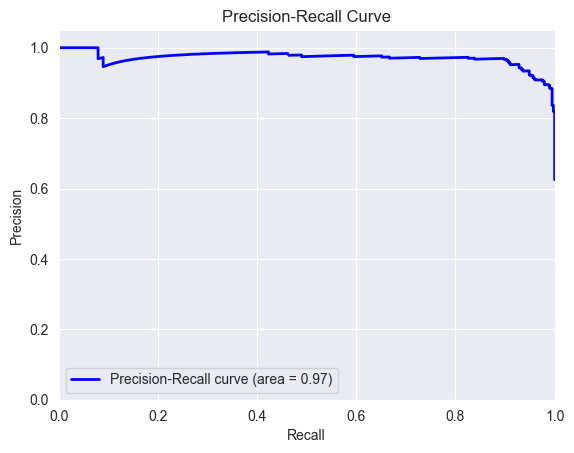

In [14]:
# Visualization of Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Precision-Recall Curve Analysis
The Precision-Recall curve further cements the model's capability with an impressive area of 0.97, reflecting high precision across almost all levels of recall. The curve plateauing near the top right suggests that the model maintains high precision even as it successfully identifies most actual pneumonia cases, a feature that is critical in reducing the number of false alarms (false positives). When juxtaposed with the baseline models, this indicates that the improved InceptionV3 maintains its reliability in predictions even as the threshold for detecting pneumonia is varied. This balance of precision and recall is particularly crucial in medical diagnostics, where it is essential to correctly identify as many true cases as possible without overwhelming the system with false positives.

## XAI with Grad-CAM & Integrated Gradients

Grad-CAM (Gradient-weighted Class Activation Mapping) and Integrated Gradients are two popular techniques for interpreting deep learning models. Grad-CAM highlights the important regions in an image that contribute to the model's prediction, while Integrated Gradients assigns an attribution score to each pixel in the image to understand its impact on the model's output. These techniques provide valuable insights into the model's decision-making process and help identify the key features influencing its predictions. I will visualise some examples using these techniques as a method of implementing XAI and improving the model's interpretability and reasoning.

### Grad-CAM XAI

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


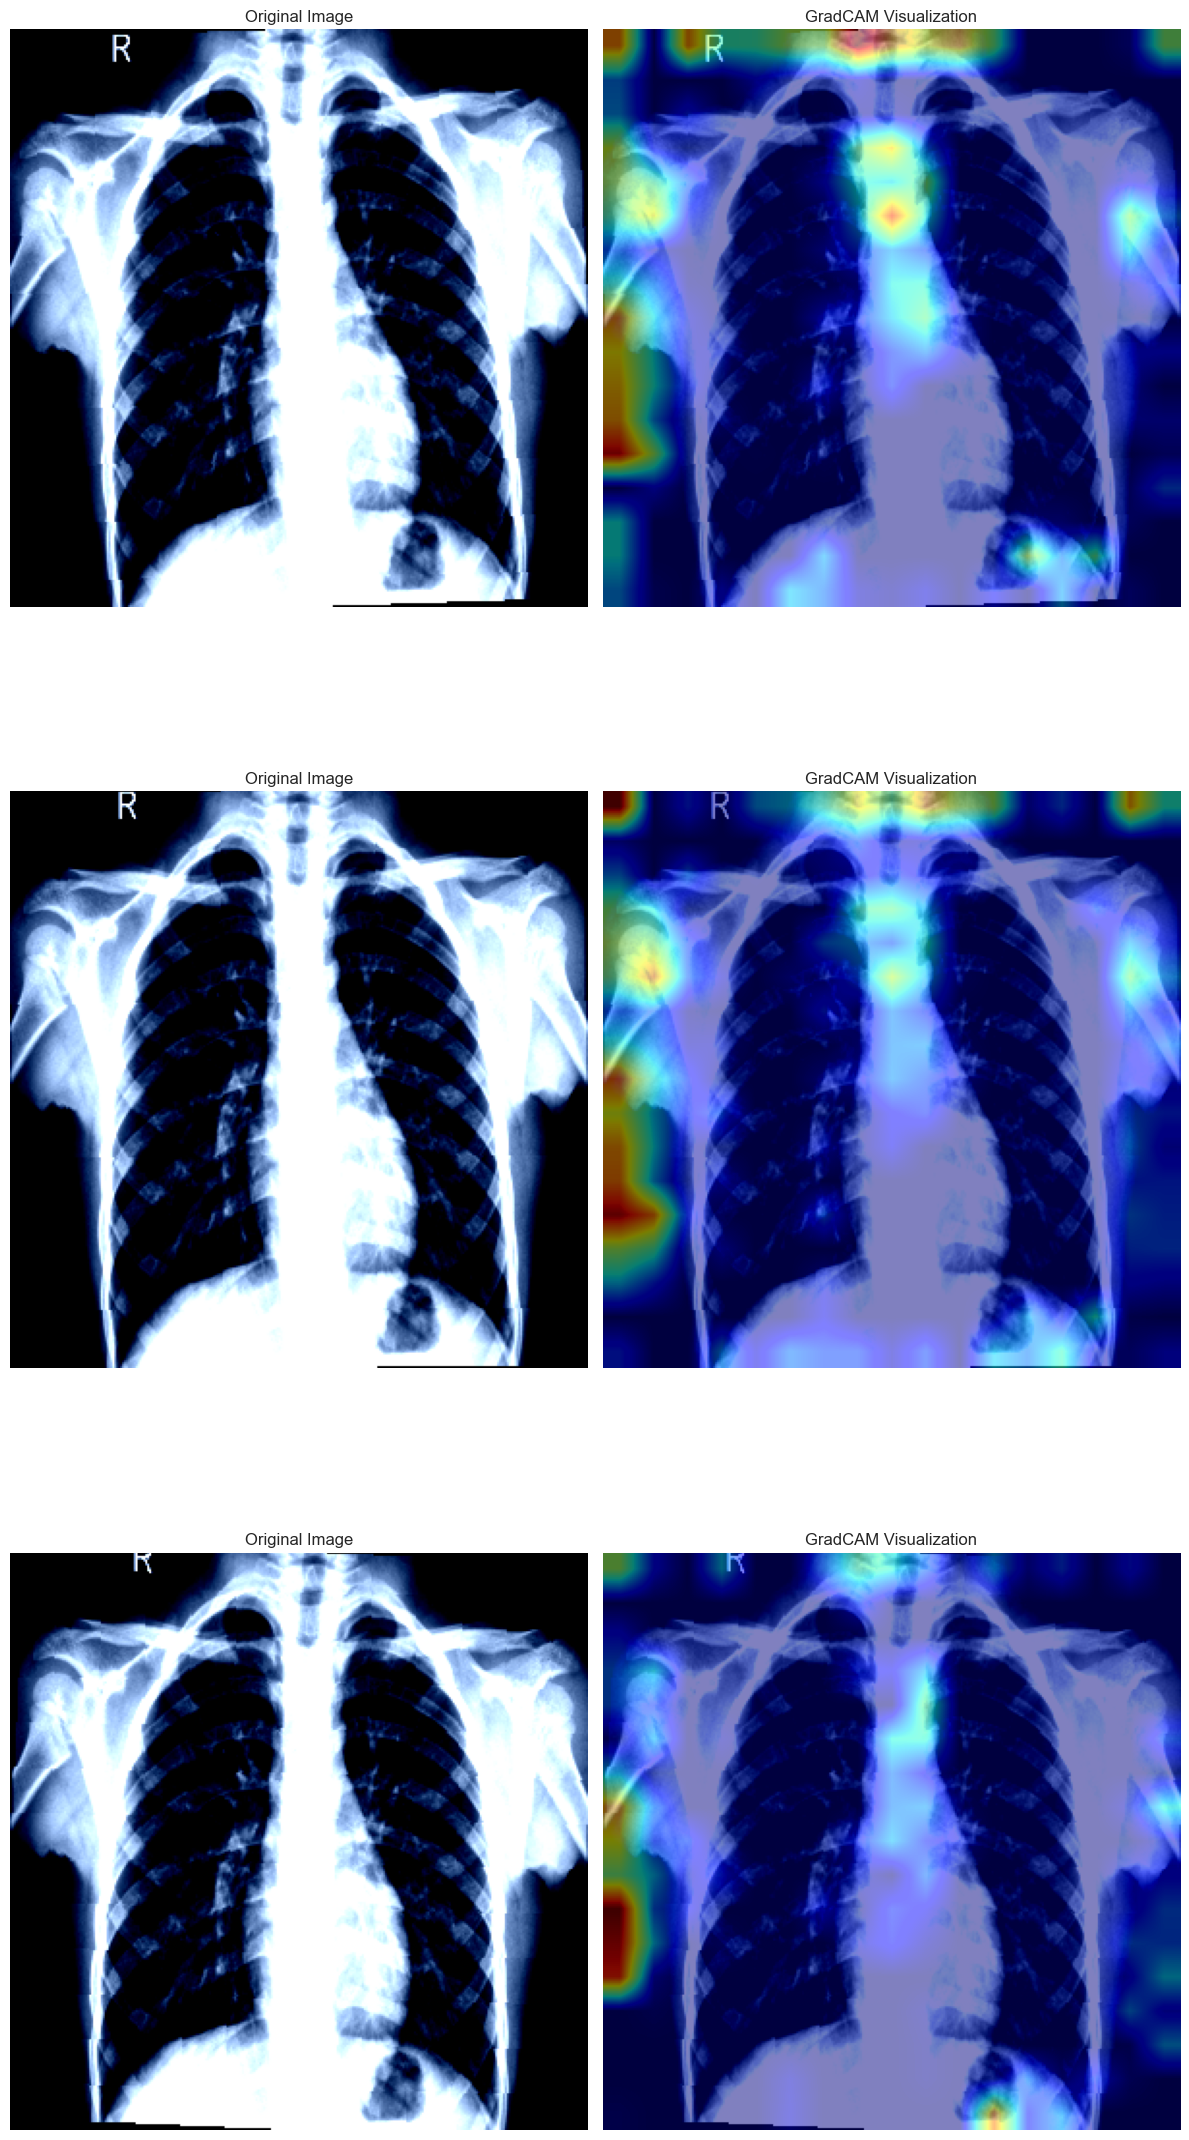

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

class GradCAM:
    """
    GradCAM implementation for InceptionV3 model.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_map = None
        self.gradients = None

        # Register forward and backward hooks
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.feature_map = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        """
        Generate GradCAM visualization.
        
        Args:
            input_tensor (torch.Tensor): Input image tensor.
            class_idx (int): Target class index. If `None`, the class with the highest probability will be used.
        
        Returns:
            np.ndarray: GradCAM heatmap.
        """
        self.model.zero_grad()
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Handle single-class output
        if output.size(1) == 1:
            one_hot_output = torch.ones_like(output)
        else:
            one_hot_output = torch.zeros_like(output)
            one_hot_output[0, class_idx] = 1
        
        output.backward(one_hot_output)
        
        # Compute gradients with respect to the feature map
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_map, dim=1)
        cam = torch.clamp(cam, 0, 1)
        
        # Resize and normalize the heatmap
        cam = cv2.resize(cam[0].detach().cpu().numpy(), input_tensor.size()[-2:])
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        return cam

# Example usage
gradcam = GradCAM(inception, inception.Mixed_6e)

# Get a few example inputs from the test_loader
example_inputs, _ = zip(*[next(iter(test_loader)) for _ in range(3)])
example_inputs = [input_tensor.to(device) for input_tensor in example_inputs]

# Generate GradCAM visualizations
fig, axes = plt.subplots(len(example_inputs), 2, figsize=(12, 8 * len(example_inputs)))

for i, input_tensor in enumerate(example_inputs):
    cam = gradcam.generate_cam(input_tensor, class_idx=1)  # Class index 1 is for pneumonia
    
    # Visualize the original input and GradCAM heatmap
    axes[i, 0].imshow(input_tensor[0].permute(1, 2, 0).cpu().numpy())
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')
    
    axes[i, 1].imshow(input_tensor[0].permute(1, 2, 0).cpu().numpy())
    axes[i, 1].imshow(cam, cmap='jet', alpha=0.5)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('GradCAM Visualization')

plt.tight_layout()
plt.show()

#### Grad-CAM Visualization Conclusion
The left part of the images are the original X-ray, and the right part shows the GradCAM visualization, which stands for Gradient-weighted Class Activation Mapping. GradCAM is an interpretability method that uses the gradients of any target concept flowing into the final convolutional layer to produce a coarse localization map, highlighting the important regions in the image for predicting the concept.

In this heat map, we can see distinct hotspots of activity—particularly around the central part of the chest and some areas around the periphery of the lungs. This implies that these regions are particularly influential for the model's predictions. Due to the model's accuracy, these correspond to areas indicative of the presence or absence of certain conditions. For instance, a hotspot in the center will be related to the heart size or the mediastinum, while peripheries may indicate issues with the lung tissue or pleura or rather just a comparison to 'clear' x-rays to recognise the haziness associated with pneumonia on x-rays.

### Integrated Gradients XAI

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


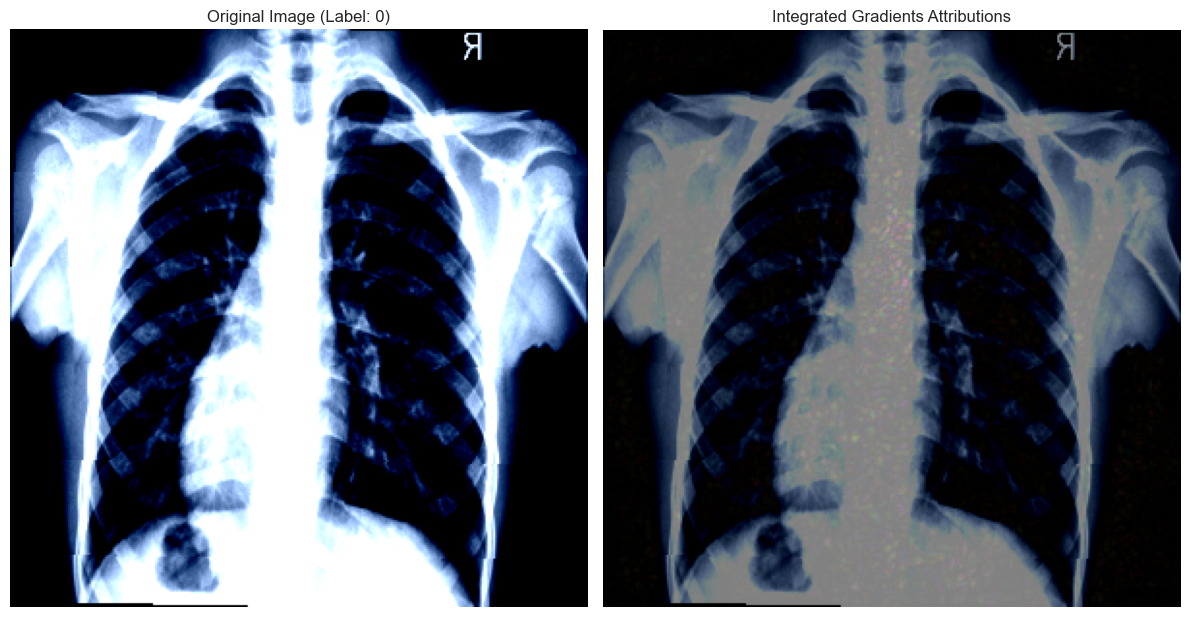

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.autograd import Function

class IntegratedGradients:
    """
    Integrated Gradients implementation for InceptionV3 model.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def generate_attributions(self, input_tensor, class_idx=None, steps=50):
        """
        Generate Integrated Gradients attributions.
        
        Args:
            input_tensor (torch.Tensor): Input image tensor.
            class_idx (int): Target class index. If `None`, the class with the highest probability will be used.
            steps (int): Number of steps to use for the numerical integration.
        
        Returns:
            np.ndarray: Integrated Gradients attributions.
        """
        self.model.zero_grad()
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Handle single-class output
        if output.size(1) == 1:
            one_hot_output = torch.ones_like(output)
        else:
            one_hot_output = torch.zeros_like(output)
            one_hot_output[0, class_idx] = 1
        
        baseline = torch.zeros_like(input_tensor)
        attributions = torch.zeros_like(input_tensor)
        
        for i in range(steps):
            alpha = i / (steps - 1)
            interpolated_input = baseline + alpha * (input_tensor - baseline)
            interpolated_input.requires_grad = True
            
            self.model.zero_grad()
            output = self.model(interpolated_input)
            output[0, class_idx].backward(retain_graph=True)
            
            gradients = interpolated_input.grad
            attributions += gradients * (input_tensor - baseline) / steps
        
        return attributions.detach().cpu().numpy()

# Example usage
integrated_gradients = IntegratedGradients(inception, inception.Mixed_6e)

# Assuming 'test_loader' and 'device' are defined, otherwise you'll need to adjust this part.
normal_dataset = [x for x in test_loader.dataset if x[1] == 0]
normal_input, normal_label = normal_dataset[0]  # Taking the first example

# Move to the correct device
input_tensor = normal_input.to(device)
label = torch.tensor([normal_label]).to(device)

# Add a batch dimension
input_tensor_with_batch = input_tensor.unsqueeze(0)

# Now generate attributions with the modified tensor
attributions = integrated_gradients.generate_attributions(input_tensor_with_batch, class_idx=label.item(), steps=50)

# Visualize the original input and Integrated Gradients attributions
fig, axes = plt.subplots(1, 2, figsize=(12, 8))  # Adjusted for a single example

input_image_np = input_tensor.cpu().detach().permute(1, 2, 0).numpy()  # Adjusted for the correct tensor shape
attribution_np = np.abs(attributions[0]).transpose(1, 2, 0)  # Assuming attributions tensor has a batch dimension

axes[0].imshow(input_image_np)
axes[0].axis('off')
axes[0].set_title(f'Original Image (Label: {label.item()})')

axes[1].imshow(input_image_np)
axes[1].imshow(attribution_np, cmap='viridis', alpha=0.5)  # Added alpha for overlay visualization
axes[1].axis('off')
axes[1].set_title('Integrated Gradients Attributions')

plt.tight_layout()
plt.show()

#### Integrated Gradients Visualisation Conclusion
The left part of the first image shows the original X-ray, while the right part displays the Integrated Gradients attributions. Integrated Gradients is a technique for interpreting machine learning models by attributing the prediction of a neural network to its input features.

The output shows certain areas of the X-ray with highlighted regions suggesting that these specific parts of the image had a significant impact on the model's prediction. These areas are likely to be where the model has detected patterns or anomalies associated with the predicted label. Since the highlighted regions are relatively diffused and cover a large portion of the lung fields, this may imply that the model is considering a broad range of features across the lungs rather than focusing on a specific abnormality. This is expected due to the haze-like appearance of pneumonia on X-rays, which can affect multiple areas of the lungs. It is good to see a lack of highlighting outside the lung fields, indicating that the model is not attributing the prediction to irrelevant parts of the image.

### Consolidated XAI Analysis

In the exploration of model interpretability for an InceptionV3 model applied to chest X-ray images, both Grad-CAM and Integrated Gradients provide valuable insights into the neural network's decision-making process.

Grad-CAM highlights areas within the X-ray images that are crucial for the model's predictions. The presence of hotspots, especially around the central chest and lung peripheries, suggests that these areas have a significant influence on the outcome. The model appears to use medically relevant features such as the size and shape of the heart and the clarity of the lung fields to distinguish between different conditions, potentially identifying the haziness characteristic of pneumonia.

Integrated Gradients, on the other hand, offers a more distributed perspective, with attributions spread across the lung fields. This distribution reflects the model's focus on a wide array of features, consistent with the diffuse patterns pneumonia typically presents on X-rays. Notably, the model's attention is appropriately confined to the lung fields, reducing the risk of basing predictions on extraneous factors outside the area of medical interest.

The X-ray analysis through both XAI techniques suggests a model finely attuned to medically pertinent features within the chest cavity. The convergence of focus on the heart and lung regions by both techniques reinforces the model's credibility in recognizing key indicators of pulmonary conditions. The Integrated Gradients' broad highlighting matches the expectation for pneumonia detection, where the condition can manifest as widespread haziness. Simultaneously, Grad-CAM's hotspots offer confidence that the model's prediction is based on concrete areas of interest rather than random or irrelevant artifacts. This consolidated understanding affirms the model's potential reliability in clinical applications, although continuous validation is imperative for ensuring its consistency and accuracy in diverse real-world scenarios.